In [71]:
__author__="Vitali Molchan"
#!/usr/bin/env python
from bs4 import BeautifulSoup
from string import find,strip
import urllib
import urllib2
import numpy as np
import glob
import time
import re
import pandas as pd
import dateutil
import matplotlib.pylab as plt
import seaborn as sns; sns.set()
from dbfread import DBF
from sets import Set
import difflib
from datetime import datetime
import bisect


In [72]:
from sklearn import datasets, linear_model
from sklearn.cross_validation import train_test_split,ShuffleSplit
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error

from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import metrics
from sklearn import preprocessing

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import RFE,f_regression

In [3]:
% matplotlib inline

In [85]:
df = pd.read_pickle("Processed_data/funda_and_cbs.pickle")
cbsBuurt2015 = pd.read_pickle("Processed_data/cbsBuurt2015.pickle")

In [86]:
print "Total number of values in dataframe is {}".format(df.shape[0])
df.dropna(subset=['WOZ'],inplace=True)
print "Number of values with available WOZ is {}".format(df.shape[0])
df.dropna(subset=['X','Y','LON','LAT'],inplace=True)
print "Number of values with available WOZ and geocoordinates is {}".format(df.shape[0])


Total number of values in dataframe is 203330
Number of values with available WOZ is 178697
Number of values with available WOZ and geocoordinates is 177705


In [87]:
minimum_date = df['SOLD_DATE'].min()
print "The earliest date is {}".format(minimum_date)
df['SOLD_DATE_DAYS'] = df['SOLD_DATE'].apply(lambda x: float((x - minimum_date).days))

The earliest date is 2009-08-25 00:00:00


In [88]:
df.head()

,FILE_NAME,PROPERTY_TYPE,PROPERTY_ID,POSTCODE_x,GEMEENTE,BUURT,OFFER_DATE,SOLD_DATE,SOLD_PRICE,ASKING_PRICE,...,WOZ,WWB_UITTOT,WW_UIT_TOT,POSTCODE,OPENBARERUIMTE,X,Y,LON,LAT,SOLD_DATE_DAYS
0,appartement-4003351-boerhaavelaan-102-a-featur...,appartement,4003351,3112LM,Schiedam,Rotterdamsedijk,2008-01-15,2015-08-08,129000.0,149000.0,...,105.0,150.0,160.0,3112LM,BOERHAAVELAAN,87878.8,436802,4.411600,51.915655,2174.0
2,appartement-4047711-dingstraat-20-features.html,appartement,4047711,7101GX,Winterswijk,Centrale deel,2007-10-31,2015-11-11,180000.0,265000.0,...,140.0,140.0,120.0,7101GX,DINGSTRAAT,246673,443112,6.721274,51.968854,2269.0
3,appartement-4096883-groningerstraat-72-d-featu...,appartement,4096883,9401BM,Assen,Galgenveld,2007-12-19,2016-01-04,175000.0,267550.0,...,145.0,40.0,20.0,9401BM,GRONINGERSTRAAT,234101,557419,6.565428,52.997921,2323.0
4,appartement-4104014-weverstraat-11-features.html,appartement,4104014,7271AJ,Borculo,Borculo Oude-Centrum,2008-04-22,2015-09-21,125000.0,158500.0,...,149.0,10.0,20.0,7271AJ,WEVERSTRAAT,232841,459232,6.523699,52.115823,2218.0
5,appartement-4127071-kerklaan-55-a-features.html,appartement,4127071,2912CJ,Nieuwerkerk,Kern Nieuwerkerk,2008-05-06,2016-05-13,295000.0,315000.0,...,226.0,0.0,10.0,2912CJ,KERKLAAN,101384,442695,4.606958,51.970083,2453.0


PROPERTY_TYPE            
appartement         count    5.243900e+04
                    mean     2.098536e+05
                    std      1.407602e+05
                    min      2.000000e+04
                    25%      1.350000e+05
                    50%      1.750000e+05
                    75%      2.390000e+05
                    max      3.600000e+06
bouwgrond           count    1.082000e+03
                    mean     2.706638e+05
                    std      2.076538e+05
                    min      1.500000e+04
                    25%      1.550000e+05
                    50%      2.250000e+05
                    75%      3.250000e+05
                    max      2.495000e+06
huis                count    1.231060e+05
                    mean     2.773150e+05
                    std      1.641522e+05
                    min      1.295000e+04
                    25%      1.850000e+05
                    50%      2.390000e+05
                    75%      3.240000e+05
        

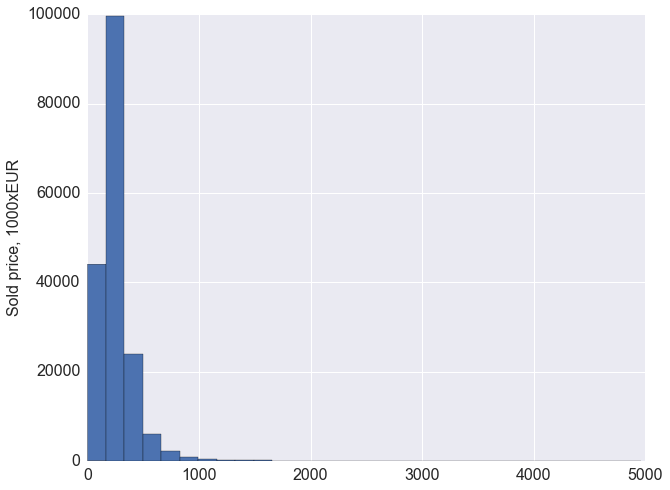

In [89]:
fig = plt.figure()
plt.figure(figsize=(10,8))

plt.hist(df['SOLD_PRICE']/1000,bins=30)
plt.ylabel('Sold price, 1000xEUR',size=16)
plt.grid(True)
plt.tick_params(labelsize=16)
print df.groupby(['PROPERTY_TYPE'])['SOLD_PRICE'].describe()

### Generic features

In [ ]:
# Garden flag
df['GARDEN_FLAG'] = 1.0
df['GARDEN_FLAG'][df['GARDEN_TYPE'].isnull()]=0.0
df['GARDEN_AREA'][df['GARDEN_FLAG']==0.0]=0.0

In [ ]:
df['GARDEN_AREA'][(df['GARDEN_FLAG']==1.0)&(df['GARDEN_AREA'].isnull())] = df['GARDEN_AREA'][df['GARDEN_FLAG']==1.0].mean()

In [ ]:
df['ENERGY_LABEL'][df['ENERGY_LABEL'].isnull()]='C'
df['PROPERTY_FLOOR'][(df['PROPERTY_FLOOR'].isnull())&(df['GARDEN_FLAG']==1.0)]=0.0

In [82]:
funda_features = ['SOLD_DATE_DAYS','YEAR_OF_BUILDING','PLOT_AREA','VOLUME','NROOMS','TOTAL_FLOORS','PROPERTY_FLOOR','GARDEN_FLAG','GARDEN_AREA','ENERGY_LABEL','X','Y','LON','LAT']
cbs_features = list(cbsBuurt2015.columns[7:])
features = funda_features+cbs_features

In [98]:
df['Y'].unique()

array([436802.091, 443112.5, 557419.0, ..., 'POPULIERENLAAN 34 F',
       'KLAVERWEIDE', 'ENNEMABORG'], dtype=object)

In [83]:
df[features].isnull().sum()

SOLD_DATE_DAYS          0
YEAR_OF_BUILDING     2198
PLOT_AREA            2264
VOLUME               2254
NROOMS               2197
TOTAL_FLOORS         2197
PROPERTY_FLOOR      12187
GARDEN_FLAG             0
GARDEN_AREA             0
ENERGY_LABEL            0
X                       0
Y                      32
LON                   965
LAT                   965
AANTAL_HH               0
AANT_INW                0
AANT_MAN                0
AANT_VROUW              0
AF_ARTSPR              64
AF_ATTRAC              64
AF_BIBLIO              64
AF_BIOS                64
AF_BRANDW              64
AF_BSO                 64
AF_CAFE                64
AF_CAFTAR              64
AF_DAGLMD              64
AF_HOTEL               64
AF_IJSBAAN             64
AF_KDV                 64
                    ...  
P_15_24_JR              0
P_1GEZW                 0
P_25_44_JR              0
P_45_64_JR              0
P_65_EO_JR              0
P_ANT_ARU               0
P_EENP_HH               0
P_GEBOO     

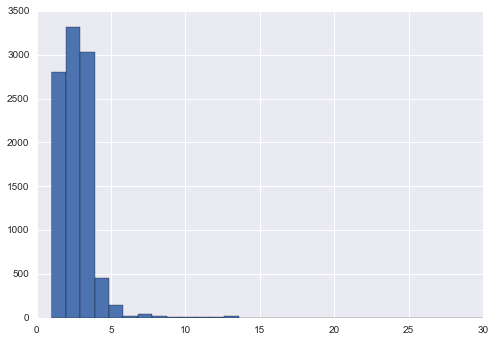

In [93]:
df['TOTAL_FLOORS'][df['PROPERTY_FLOOR'].isnull()].hist(bins=30)

Number of items with indefined PROPERTY_FLOOR attribute is 12187. Let's separate these data from the dataframe for now.

In [84]:
for el,feature in zip(df[features].isnull().sum(),features):
    print feature,el

SOLD_DATE_DAYS 0
YEAR_OF_BUILDING 2198
PLOT_AREA 2264
VOLUME 2254
NROOMS 2197
TOTAL_FLOORS 2197
PROPERTY_FLOOR 12187
GARDEN_FLAG 0
GARDEN_AREA 0
ENERGY_LABEL 0
X 0
Y 32
LON 965
LAT 965
AANTAL_HH 0
AANT_INW 0
AANT_MAN 0
AANT_VROUW 0
AF_ARTSPR 64
AF_ATTRAC 64
AF_BIBLIO 64
AF_BIOS 64
AF_BRANDW 64
AF_BSO 64
AF_CAFE 64
AF_CAFTAR 64
AF_DAGLMD 64
AF_HOTEL 64
AF_IJSBAAN 64
AF_KDV 64
AF_OPRITH 64
AF_OVERST 64
AF_RESTAU 64
AF_SAUNA 64
AF_SUPERM 64
AF_TREINST 64
AF_WARENH 64
AF_ZONBNK 64
AF_ZWEMB 64
AO_UIT_TOT 0
AUTO_HH 812
AUTO_LAND 812
AUTO_TOT 0
AV10ATTRAC 64
AV10WARENH 64
AV10_BIOS 64
AV10_HOTEL 64
AV1_ARTSPR 64
AV1_BSO 64
AV1_CAFE 64
AV1_CAFTAR 64
AV1_DAGLMD 64
AV1_KDV 64
AV1_RESTAU 64
AV1_SUPERM 64
AV20ATTRAC 64
AV20WARENH 64
AV20_BIOS 64
AV20_HOTEL 64
AV3_ARTSPR 64
AV3_BSO 64
AV3_CAFE 64
AV3_CAFTAR 64
AV3_DAGLMD 64
AV3_KDV 64
AV3_RESTAU 64
AV3_SUPERM 64
AV50ATTRAC 64
AV5_ARTSPR 64
AV5_BIOS 64
AV5_BSO 64
AV5_CAFE 64
AV5_CAFTAR 64
AV5_DAGLMD 64
AV5_HOTEL 64
AV5_KDV 64
AV5_RESTAU 64
AV5_SUPER

In [41]:
df.fillna(df.mean(),inplace=True)

,FILE_NAME,PROPERTY_TYPE,PROPERTY_ID,POSTCODE_x,GEMEENTE,BUURT,OFFER_DATE,SOLD_DATE,SOLD_PRICE,ASKING_PRICE,...,WWB_UITTOT,WW_UIT_TOT,POSTCODE,OPENBARERUIMTE,X,Y,LON,LAT,SOLD_DATE_DAYS,GARDEN_FLAG
0,appartement-4003351-boerhaavelaan-102-a-featur...,appartement,4003351,3112LM,Schiedam,Rotterdamsedijk,2008-01-15,2015-08-08,129000.0,149000.000000,...,150.0,160.0,3112LM,BOERHAAVELAAN,87878.782,436802.091,4.411600,51.915655,2174.0,1.0
2,appartement-4047711-dingstraat-20-features.html,appartement,4047711,7101GX,Winterswijk,Centrale deel,2007-10-31,2015-11-11,180000.0,265000.000000,...,140.0,120.0,7101GX,DINGSTRAAT,246673.398,443112.500,6.721274,51.968854,2269.0,0.0
3,appartement-4096883-groningerstraat-72-d-featu...,appartement,4096883,9401BM,Assen,Galgenveld,2007-12-19,2016-01-04,175000.0,267550.000000,...,40.0,20.0,9401BM,GRONINGERSTRAAT,234101.000,557419.000,6.565428,52.997921,2323.0,0.0
4,appartement-4104014-weverstraat-11-features.html,appartement,4104014,7271AJ,Borculo,Borculo Oude-Centrum,2008-04-22,2015-09-21,125000.0,158500.000000,...,10.0,20.0,7271AJ,WEVERSTRAAT,232841.480,459231.638,6.523699,52.115823,2218.0,0.0
5,appartement-4127071-kerklaan-55-a-features.html,appartement,4127071,2912CJ,Nieuwerkerk,Kern Nieuwerkerk,2008-05-06,2016-05-13,295000.0,315000.000000,...,0.0,10.0,2912CJ,KERKLAAN,101384.000,442695.000,4.606958,51.970083,2453.0,0.0
6,appartement-4128139-aristide-briandring-20-fea...,appartement,4128139,3137DB,Vlaardingen,Loper Noord,2008-05-07,2015-11-15,169500.0,195000.000000,...,10.0,30.0,3137DB,ARISTIDE BRIANDRING,83318.222,438829.875,4.344900,51.933310,2273.0,0.0
7,appartement-4131363-eindstraat-106-features.html,appartement,4131363,5801CR,Venray,Venray-Centrum,2008-05-20,2015-09-29,169000.0,224000.000000,...,30.0,60.0,5801CR,EINDSTRAAT,195726.609,393609.624,5.974122,51.529994,2226.0,0.0
8,appartement-4143773-kromhout-216-features.html,appartement,4143773,3311RJ,Dordrecht,Kasperspad en omgeving,2008-02-22,2015-12-21,295000.0,324900.000000,...,70.0,40.0,3311RJ,KROMHOUT,105653.332,425061.582,4.671608,51.811994,2309.0,0.0
9,appartement-4156914-zwartwatersweg-131-feature...,appartement,4156914,9402SM,Assen,Zwarte Water,2008-02-26,2016-07-01,105000.0,134500.000000,...,90.0,30.0,9402SM,ZWARTWATERSWEG,233652.000,558332.000,6.558962,53.006189,2502.0,1.0
11,appartement-4202107-de-marke-180-features.html,appartement,4202107,9203DX,Drachten,Centrum,2008-07-24,2015-10-15,125000.0,147500.000000,...,30.0,30.0,9203DX,DE MARKE,202789.746,568825.528,6.100770,53.104100,2242.0,0.0


### Feature encoding and scaling

In [42]:
# Discreet value integer encoder
label_encoder = preprocessing.LabelEncoder()

In [43]:
df['ENERGY_LABEL'] = label_encoder.fit_transform(df['ENERGY_LABEL'])
df['PROPERTY_TYPE'] = label_encoder.fit_transform(df['PROPERTY_TYPE'])

In [44]:
df[features]

,SOLD_DATE_DAYS,YEAR_OF_BUILDING,PLOT_AREA,VOLUME,NROOMS,TOTAL_FLOORS,PROPERTY_FLOOR,GARDEN_FLAG,GARDEN_AREA,ENERGY_LABEL,...,P_VERWEDUW,P_WEST_AL,P_WONT2000,P_WONV2000,STED,STERFT_TOT,WONINGEN,WOZ,WWB_UITTOT,WW_UIT_TOT
0,2174.0,1928.000000,110.000000,230.000000,4.000000,2.000000,0.000000,1.0,50.000000,2,...,3.0,22.0,100.0,0.0,1.0,15.0,1895.0,105.0,150.0,160.0
2,2269.0,2000.000000,93.000000,260.000000,3.000000,2.000000,2.000000,0.0,0.000000,1,...,8.0,10.0,80.0,20.0,2.0,45.0,2108.0,140.0,140.0,120.0
3,2323.0,2008.000000,99.000000,290.000000,4.000000,4.000000,4.000000,0.0,0.000000,0,...,10.0,11.0,49.0,51.0,1.0,5.0,485.0,145.0,40.0,20.0
4,2218.0,1985.000000,95.000000,280.000000,4.000000,2.000000,2.000000,0.0,0.000000,2,...,5.0,4.0,87.0,13.0,3.0,0.0,287.0,149.0,10.0,20.0
5,2453.0,2003.000000,90.000000,270.000000,3.000000,2.000000,1.000000,0.0,0.000000,1,...,4.0,6.0,90.0,10.0,2.0,0.0,110.0,226.0,0.0,10.0
6,2273.0,1989.000000,77.000000,210.000000,3.000000,1.000000,3.000000,0.0,0.000000,2,...,3.0,7.0,100.0,0.0,1.0,5.0,530.0,174.0,10.0,30.0
7,2226.0,2001.000000,110.000000,270.000000,3.000000,2.000000,2.000000,0.0,0.000000,0,...,12.0,13.0,67.0,33.0,2.0,30.0,1089.0,160.0,30.0,60.0
8,2309.0,2007.000000,115.000000,340.000000,4.000000,4.000000,3.000000,0.0,0.000000,0,...,4.0,13.0,92.0,8.0,1.0,5.0,548.0,145.0,70.0,40.0
9,2502.0,1965.000000,95.000000,250.000000,4.000000,4.000000,0.000000,1.0,101.655346,4,...,4.0,11.0,87.0,13.0,2.0,10.0,640.0,118.0,90.0,30.0
11,2242.0,1970.000000,96.000000,300.000000,4.000000,12.000000,8.000000,0.0,0.000000,4,...,13.0,6.0,77.0,23.0,2.0,15.0,831.0,140.0,30.0,30.0


In [54]:
df[features].isnull().sum()

SOLD_DATE_DAYS      0
YEAR_OF_BUILDING    0
PLOT_AREA           0
VOLUME              0
NROOMS              0
TOTAL_FLOORS        0
PROPERTY_FLOOR      0
GARDEN_FLAG         0
GARDEN_AREA         0
ENERGY_LABEL        0
X                   0
Y                   0
LON                 0
LAT                 0
AANTAL_HH           0
AANT_INW            0
AANT_MAN            0
AANT_VROUW          0
AF_ARTSPR           0
AF_ATTRAC           0
AF_BIBLIO           0
AF_BIOS             0
AF_BRANDW           0
AF_BSO              0
AF_CAFE             0
AF_CAFTAR           0
AF_DAGLMD           0
AF_HOTEL            0
AF_IJSBAAN          0
AF_KDV              0
                   ..
P_15_24_JR          0
P_1GEZW             0
P_25_44_JR          0
P_45_64_JR          0
P_65_EO_JR          0
P_ANT_ARU           0
P_EENP_HH           0
P_GEBOO             0
P_GEHUWD            0
P_GESCHEID          0
P_HH_M_K            0
P_HH_Z_K            0
P_MAROKKO           0
P_MGEZW             0
P_N_W_AL  

## Features selection

#### Method#1 - Pearson correlation coefficient

In [57]:
# Find a correlation between SOLD_PRICE and other attributes
# Print only attibutes with correlation above threshold (0.25)
corMat = df[features+['SOLD_PRICE']].corr()
correlations_above_threshold = corMat['SOLD_PRICE'][np.abs(corMat['SOLD_PRICE'])>0.05].sort_values(ascending=True)

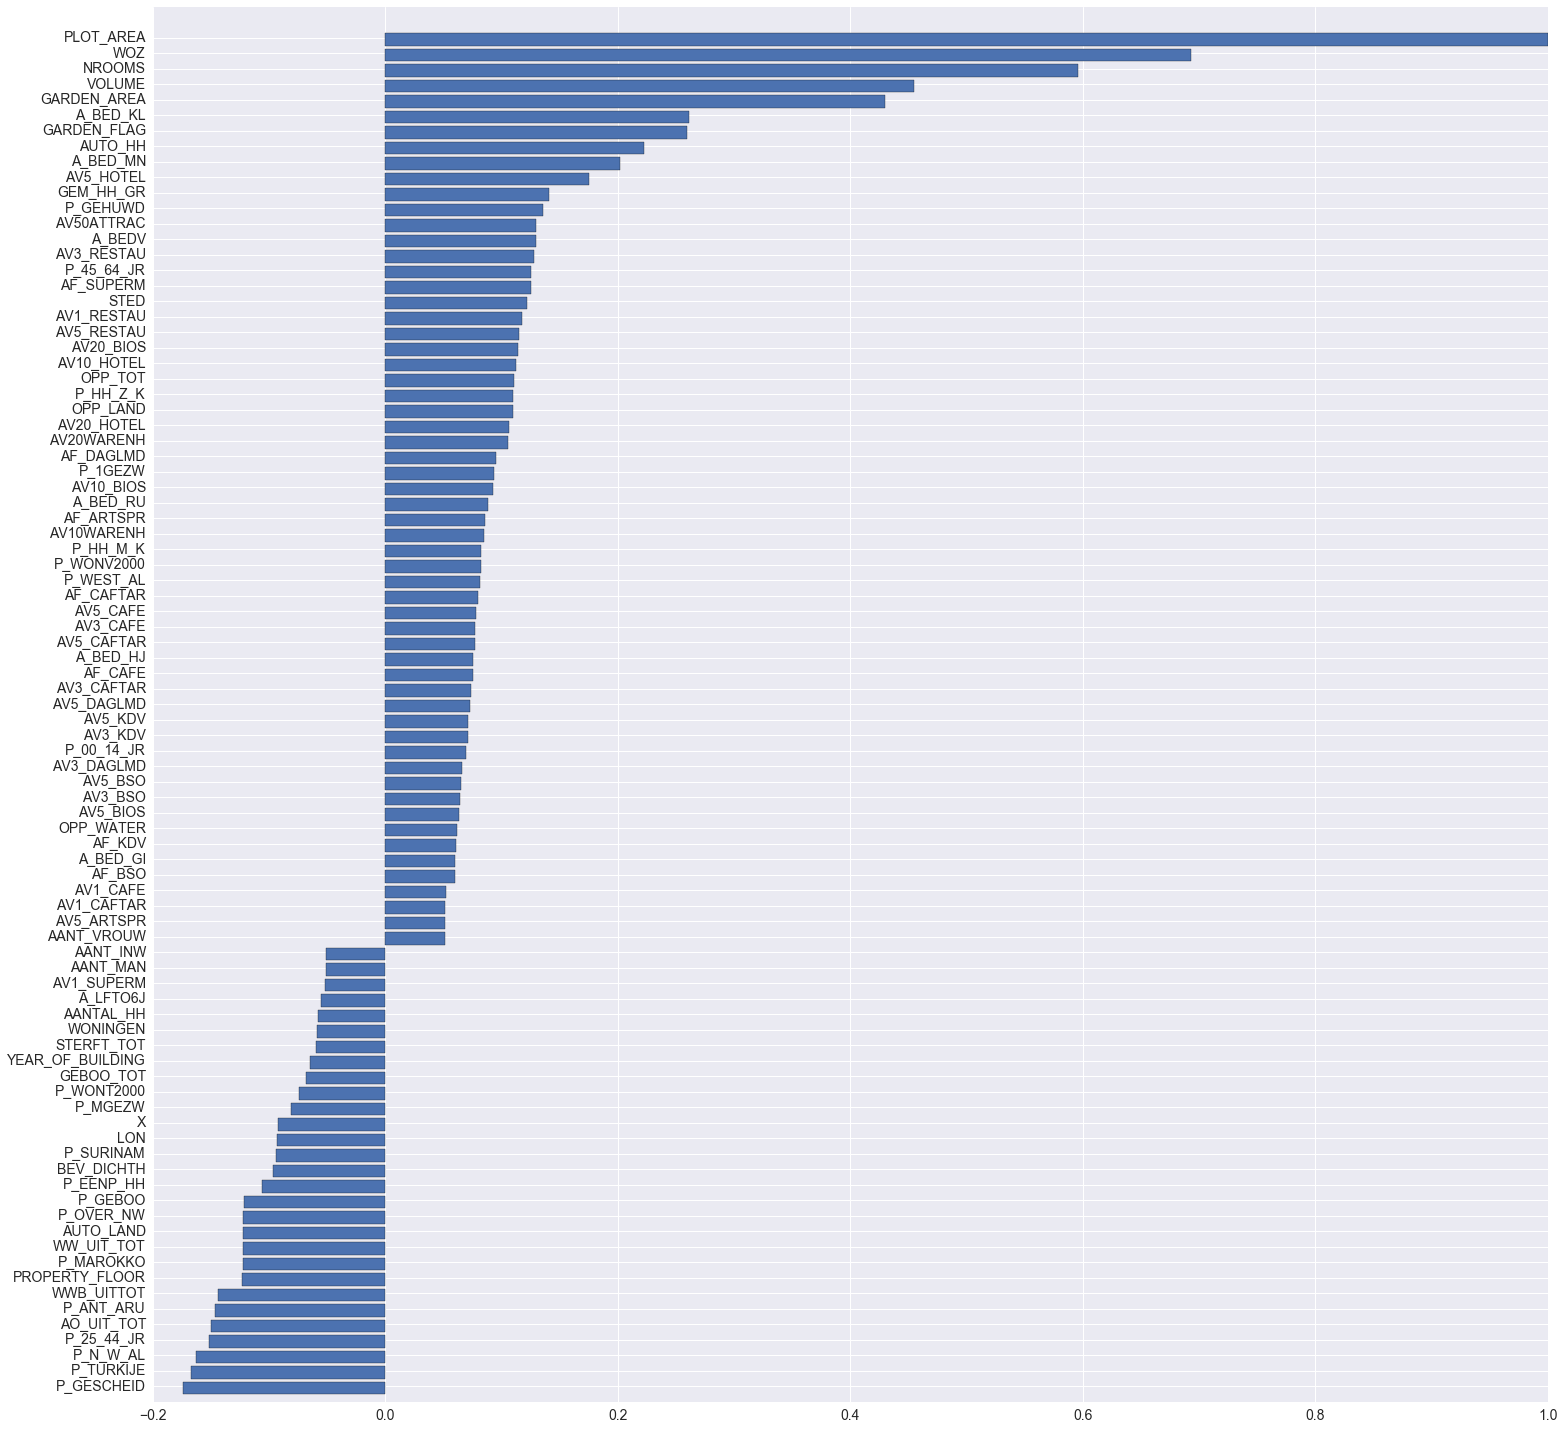

In [58]:
fig = plt.figure()
plt.figure(figsize=(25,25))
plt.barh(np.arange(len(correlations_above_threshold)-1)+0.5,correlations_above_threshold.iloc[1:])
plt.yticks(np.arange(1,len(correlations_above_threshold)),correlations_above_threshold.index)
#plt.yticks(np.arange(0,len(correlations_above_threshold)),correlations_above_threshold,rotation=0)
plt.grid(True)
plt.tick_params(labelsize=14)


Certain positive correlation exists between price of the property and area(PLOT_AREA)/number of rooms (NROOM) and property volume (VOLUME), WOZ (average property value according to the CBS statistics) and
business activity (A_BEDV_KL).

#### Method#2 - Ranking features using Random forest model

In [ ]:
X = df[features].as_matrix()
Y = np.ravel(df['SOLD_PRICE'])

#Standard scaler
scaler = preprocessing.StandardScaler()

X = scaler.fit_transform(X)
Y = scaler.fit_transform(Y)



names = features
 
rf = ensemble.RandomForestRegressor(n_estimators=20, max_depth=1)
scores = []
for i in range(X.shape[1]):
    score = cross_validation.cross_val_score(rf, X[:, i:i+1], Y, scoring="r2",cv=ShuffleSplit(len(X), 3, .3))
    scores.append((round(np.mean(score), 3), names[i]))

In [60]:
corr_coefs = []
names = []
for el in sorted(scores,reverse=True):
    corr_coefs.append(el[0])
    names.append(el[1])


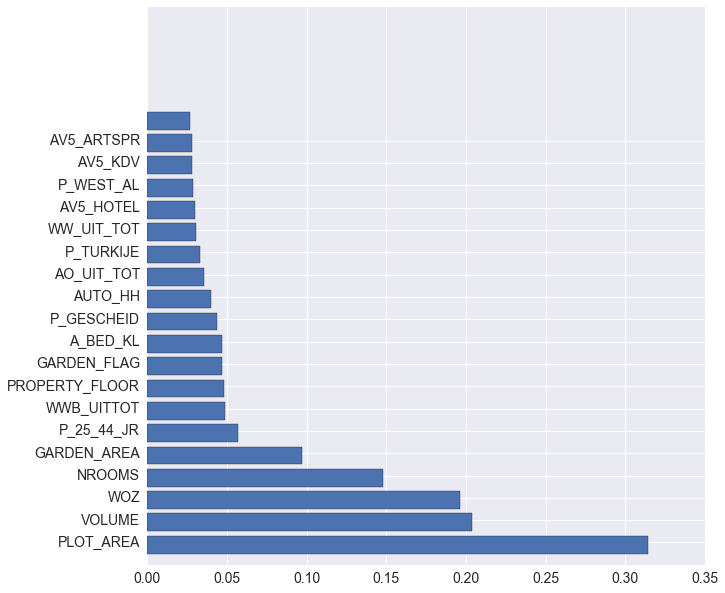

In [64]:
fig = plt.figure()
plt.figure(figsize=(10,10))
plt.barh(np.arange(len(corr_coefs[:20]))+0.5,corr_coefs[:20])
plt.yticks(np.arange(1,len(corr_coefs[:20])),names[:20])
plt.grid(True)
plt.tick_params(labelsize=14)

### Method#3 - Ranking features using Linear model

c:\Users\vitali_molchan\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


['PLOT_AREA', u'WOZ', u'AV3_RESTAU', u'AV5_RESTAU', u'AV20_BIOS', u'AV20_HOTEL', u'A_BED_KL', u'AV3_BSO', u'AV50ATTRAC', u'AV10_BIOS', u'P_EENP_HH', 'VOLUME', u'AV5_HOTEL', 'GARDEN_AREA', 'LON', u'AV1_RESTAU', u'AUTO_HH', u'AF_RESTAU', u'STED', 'SOLD_DATE_DAYS', 'GARDEN_FLAG', u'AF_DAGLMD', u'P_GEHUWD', u'AF_CAFTAR', u'AF_SUPERM', 'LAT', 'X', u'AV20ATTRAC', u'A_BST_NB', 'ENERGY_LABEL', u'AF_BRANDW', u'AF_ZWEMB', u'P_HH_Z_K', u'AUTO_LAND', u'P_SURINAM', u'P_GEBOO', u'P_25_44_JR', u'P_GESCHEID', u'GEM_HH_GR', 'YEAR_OF_BUILDING', 'PROPERTY_FLOOR', u'P_WONT2000', u'P_WONV2000', u'A_LFTJ6J', u'AV10ATTRAC', u'AF_OPRITH', u'DEK_PERC', u'P_MAROKKO', u'AF_ZONBNK', u'P_15_24_JR', u'AF_SAUNA', u'AV5_CAFE', u'AV1_CAFE', u'AV3_ARTSPR', u'P_TURKIJE', u'P_OVER_NW', u'P_WEST_AL', u'AV20WARENH', u'A_BED_HJ', u'AF_ARTSPR', u'AV5_BSO', u'OPP_TOT', u'AO_UIT_TOT', u'A_LFTO6J', u'AF_BSO', u'A_BED_RU', 'TOTAL_FLOORS', u'AF_KDV', u'GEBOO_TOT', u'WWB_UITTOT', u'AF_IJSBAAN', u'BEDR_AUTO', u'P_ANT_ARU', u'STERFT

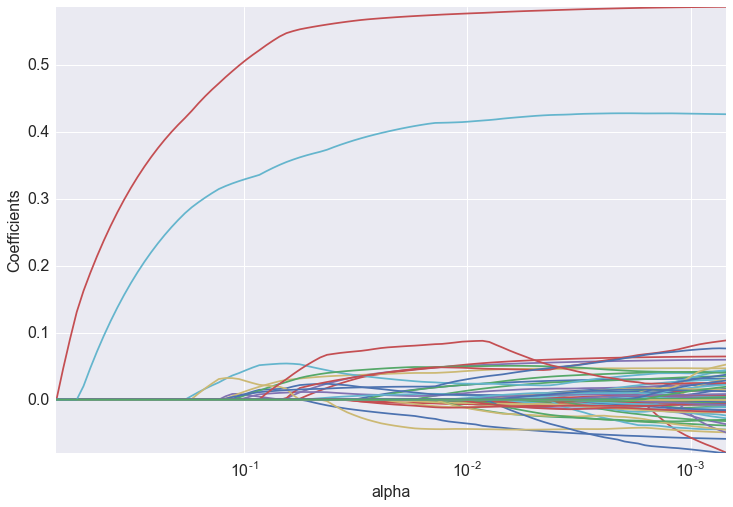

In [65]:
alphas, coefs, _ = linear_model.lasso_path(X,Y, return_model=False)

fig = plt.figure()
plt.figure(figsize=(12,8))
plt.plot(alphas,coefs.T)
plt.xlabel('alpha',size=16)
plt.ylabel('Coefficients',size=16)
plt.axis('tight')
plt.semilogx()
ax = plt.gca()
ax.invert_xaxis()
plt.tick_params(labelsize=16)
plt.grid(True)
plt.legend(loc='best')

nattr, nalpha = coefs.shape
AttributeOrdered = []

for iAlpha in range(1,nalpha):
    for attr in df[features].columns[np.where(coefs[:,iAlpha]!=0)].values:
        if attr not in AttributeOrdered:
            AttributeOrdered.append(attr)

print AttributeOrdered


Interesting to notice that PLOT_AREA and VOLUME have very different ranks. It is the opposite in other methods.

### Method#4 - Forward stepwise best attribute selection

In [66]:
def xattrSelect(x, idxSet):
    #takes X matrix as list of list and returns subset containing columns in idxSet
    xOut = []
    for row in x:
        xOut.append([row[i] for i in idxSet])
    return(xOut)

In [67]:
xListTrain, xListTest, labelsTrain, labelsTest = train_test_split(X, Y,test_size=0.3)


#build list of attributes one-at-a-time - starting with empty
attributeList = []
index = range(len(features))
indexSet = set(index)
indexSeq = []
oosError = []

for i in index:
    attSet = set(attributeList)
    #print sorted(attributeList)
    #attributes not in list already
    attTrySet = indexSet - attSet
    #form into list
    attTry = [ii for ii in attTrySet]
    errorList = []
    attTemp = []
    #try each attribute not in set to see which one gives least oos error
    for iTry in attTry:
        attTemp = [] + attributeList
        attTemp.append(iTry)
        #use attTemp to form training and testing sub matrices as list of lists
        xTrainTemp = xattrSelect(xListTrain, attTemp)
        xTestTemp = xattrSelect(xListTest, attTemp)
        #form into numpy arrays
        xTrain = np.array(xTrainTemp)
        yTrain = np.array(labelsTrain)
        xTest = np.array(xTestTemp)
        yTest = np.array(labelsTest)
        #use sci-kit learn linear regression
        LinearModel = linear_model.LinearRegression()
        LinearModel.fit(xTrain,yTrain)
        #use trained model to generate prediction and calculate rmsError
        rmsError = round(np.linalg.norm((yTest-LinearModel.predict(xTest)), 2)/np.sqrt(len(yTest)),3)
        #print rmsError,np.sqrt(mean_squared_error(yTest,LinearModel.predict(xTest)))
        errorList.append(rmsError)
        attTemp = []

    iBest = np.argmin(errorList)
    attributeList.append(attTry[iBest])
    oosError.append(errorList[iBest])

Out of sample error versus attribute set size
[0.735, 0.611, 0.567, 0.559, 0.555, 0.552, 0.55, 0.548, 0.547, 0.546, 0.545, 0.544, 0.543, 0.542, 0.542, 0.542, 0.541, 0.541, 0.541, 0.541, 0.541, 0.54, 0.54, 0.54, 0.54, 0.54, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.539, 0.538, 0.538, 0.538, 0.538, 0.538, 0.538, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.536, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535]

Best attribute indic

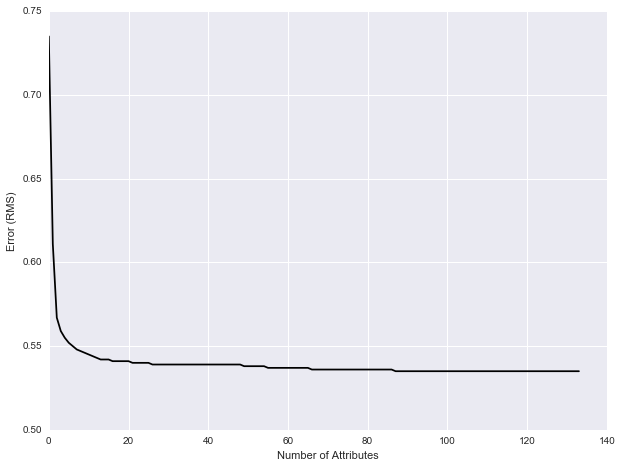

In [68]:
print("Out of sample error versus attribute set size" )
print(oosError)
print("\n" + "Best attribute indices")
print(attributeList)
namesList = [names[i] for i in attributeList]
print("\n" + "Best attribute names")
print(namesList)

#Plot error versus number of attributes
x = range(len(oosError))
fig = plt.figure()
plt.figure(figsize=(10,7.5))
plt.plot(x, oosError, 'k')
plt.xlabel('Number of Attributes')
plt.ylabel('Error (RMS)')


### Method#5 -  Lasso, Rigid, Stability method

In [69]:
names = features

ranks = {}
methods = []

def rank_to_dict(ranks,names,order=1):
    minmax = preprocessing.MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T)
    ranks = map(lambda x: round(x,3), ranks)
    return dict(zip(names, ranks))


ranks = {}



lr = linear_model.LinearRegression()
lr.fit(X,Y)
ranks['Linear'] = rank_to_dict(np.abs(lr.coef_),features)

ridge = linear_model.Ridge(alpha=7)
ridge.fit(X,Y)
ranks['Ridge '] = rank_to_dict(np.abs(ridge.coef_),features)


lasso = linear_model.Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), features)
 
    
rlasso = linear_model.RandomizedLasso()
rlasso.fit(X, Y)
ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), features)


#stop the search when 10 features are left (they will get equal scores)
rfe = RFE(lr, n_features_to_select=10)
rfe.fit(X,Y)
ranks["RFE"] = rank_to_dict(map(float, rfe.ranking_), features, order=-1)


rf = ensemble.RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, features)
 
    
f, pval  = f_regression(X, Y, center=True)
ranks["Corr."] = rank_to_dict(f, features)


methods = sorted(ranks.keys())

c:\Users\vitali_molchan\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 140 iterations, alpha=2.085e-05, previous alpha=3.138e-07, with an active set of 117 regressors.
  ConvergenceWarning)


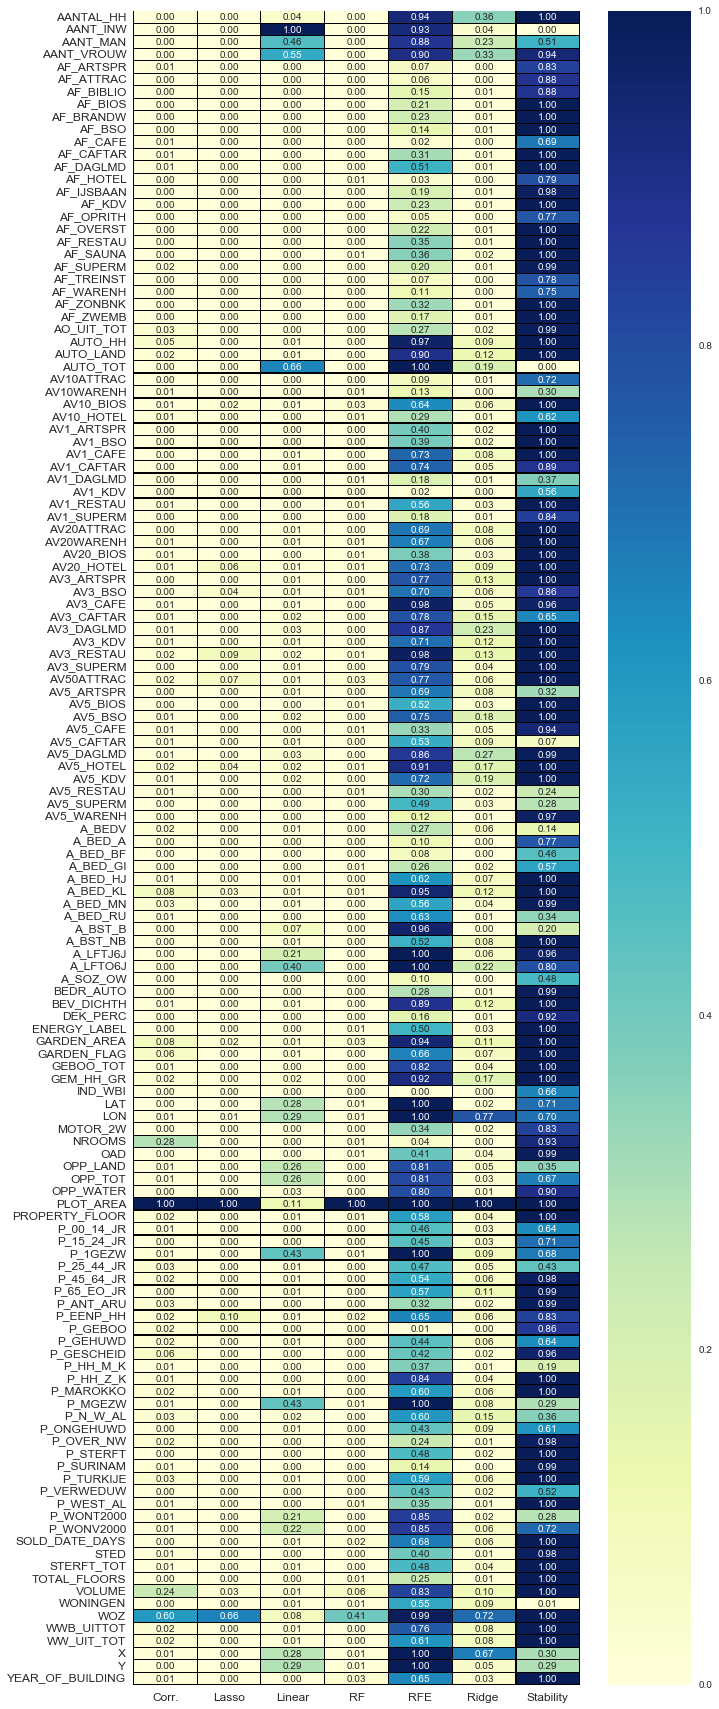

In [70]:
SensitivityCoef = pd.DataFrame(ranks)
fig = plt.figure()
plt.figure(figsize=(10,30))
sns.heatmap(SensitivityCoef,cmap="YlGnBu",linecolor='Black',linewidths=0.1,annot=True,fmt=".2f")
plt.tick_params(labelsize=12)

PLOT_AREA is top performed attribute among others almost in all metrics. Lasso method highlightes three attrbutes (the most important from performance point of view) - PLOT_AREA, WOZ and AV5_HOTEL.

In [ ]:
df.groupby(['GM_NAAM','BU_NAAM'])['SOLD_PRICE'].agg(['mean']).head(-20)

In [ ]:
buurt_statistics = df.groupby(['GM_NAAM','BU_NAAM'])['SOLD_PRICE'].agg(['mean','count'])
buurt_statistics['total_sum'] = buurt_statistics['mean']*buurt_statistics['count']
buurt_statistics.reset_index(inplace=True)
buurt_statistics.groupby('GM_NAAM')['total_sum'].agg('sum')/buurt_statistics.groupby('GM_NAAM')['count'].agg('sum')

In [ ]:
df[(df['SOLD_DATE']>datetime(2014,1,1))&(df['SOLD_DATE']<datetime(2015,1,1))]

## Model building

### Error metrics

In [505]:
def mismatch_scatter_plot(yTest,yPred):
    yTest = scaler.inverse_transform(yTest)
    yPred = scaler.inverse_transform(yPred)
    max_price = np.max([max(yTest),np.max(yPred)])
    min_price = np.min([min(yTest),np.min(yPred)])
    fig = plt.figure()
    plt.figure(figsize=(10,7.5))
    plt.scatter(yTest,yPred,s=26,color='black',alpha=0.4)
    plt.plot([min_price,max_price],[min_price,max_price],color='red', linestyle='--')
    plt.tick_params(labelsize=16) 
    plt.xlim([min_price,max_price])
    plt.ylim([min_price,max_price])
    plt.xlabel("Observed price, EUR", size=16)
    plt.ylabel("Predicted price, EUR", size=16)

def mismatch_boxplot_per_category(predictionQC,model_name):
    plt.figure(figsize=(15,12))
    predictionQC.boxplot(column = 'delta',by = 'categories',figsize=(15,12))
    plt.ylim([-200000,200000])
    plt.title("{}\nDelta:  calculated price-observed price, EUR".format(model_name),size=20)
    plt.tick_params(labelsize=16)
    plt.xlabel("Appartment categories",size=16)
    
def make_predictionQC_df(Y,prediction):
    predictionQC = pd.DataFrame({'OBSERVED_PRICE':Y,'PREDICTED_PRICE':predictions}).apply(lambda x: scaler.inverse_transform(x))
    predictionQC['delta'] = predictionQC['PREDICTED_PRICE']-predictionQC['OBSERVED_PRICE']
    bins = [0,25000,100000,150000,200000,250000,350000,500000,3000000]
    group_names = ['<25k', '25-100k', '100-150k', '150-200k','200-250k','250-350k','350-500k','>500k']
    predictionQC['categories'] = pd.cut(predictionQC['OBSERVED_PRICE'], bins, labels=group_names)
    return predictionQC

### Attempt#1 - Gradient boosting (manual) with all features

In [380]:
xListTrain, xListTest, yListTrain, yListTest = train_test_split(X, Y,test_size=0.2)

print(xListTest.shape)
print(xListTrain.shape)
print('Training/Test Ratio: {:.2f}'.format(float(xListTrain.shape[0]) /float(xListTest.shape[0])))

(9471L, 129L)
(37881L, 129L)
Training/Test Ratio: 4.00


In [381]:
parameters = {
              'n_estimators': 25, 
              'max_depth': 5, 
              'min_samples_split': 1,
              'learning_rate': 0.01, 
              'loss': 'ls'
             }
classifier = ensemble.GradientBoostingRegressor(**parameters)

classifier.fit(xListTrain, yListTrain)
predictions = classifier.predict(xListTet)
mse = metrics.mean_squared_error(yListTest, predictions)
print('Mean Square Error: {:.2f}'.format(mse))

Mean Square Error: 0.64


In [383]:
parameters = {
              'n_estimators': 100, 
              'max_depth': 5, 
              'min_samples_split': 1,
              'learning_rate': 0.01, 
              'loss': 'ls'
             }
classifier = ensemble.GradientBoostingRegressor(**parameters)

classifier.fit(xListTrain, yListTrain)
predictions = classifier.predict(xListTest)
mse = metrics.mean_squared_error(yListTest, predictions)
print('Mean Square Error: {:.2f}'.format(mse))

Mean Square Error: 0.26


In [385]:
parameters = {
              'n_estimators': 300, 
              'max_depth': 10, 
              'min_samples_split': 1,
              'learning_rate': 0.01, 
              'loss': 'ls'
             }
classifier = ensemble.GradientBoostingRegressor(**parameters)

classifier.fit(xListTrain, yListTrain)
predictions = classifier.predict(xListTest)
mse = metrics.mean_squared_error(yListTest, predictions)
print('Mean Square Error: {:.2f}'.format(mse))

Mean Square Error: 0.10


In [471]:
predictionQC = pd.DataFrame({'OBSERVED_PRICE':yListTest,'PREDICTED_PRICE':predictions}).apply(lambda x: scaler.inverse_transform(x))
predictionQC['delta'] = predictionQC['PREDICTED_PRICE']-predictionQC['OBSERVED_PRICE']


In [459]:
bins = [0,25000,100000,150000,200000,250000,350000,500000,3000000]
group_names = ['<25k', '25-100k', '100-150k', '150-200k','200-250k','250-350k','350-500k','>500k']
predictionQC['categories'] = pd.cut(predictionQC['OBSERVED_PRICE'], bins, labels=group_names)

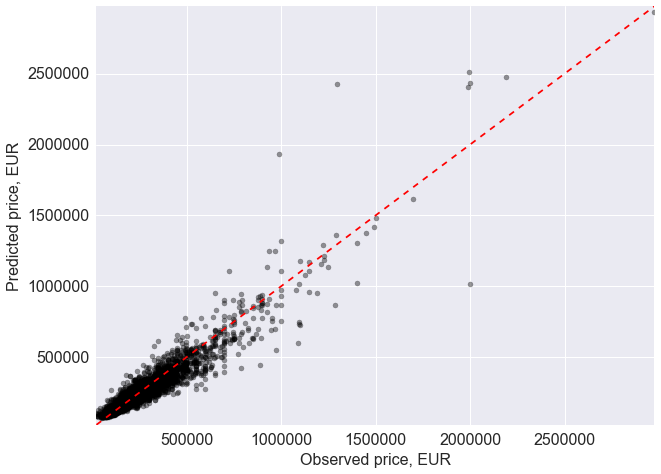

In [469]:
mismatch_scatter_plot(yListTest,predictions)

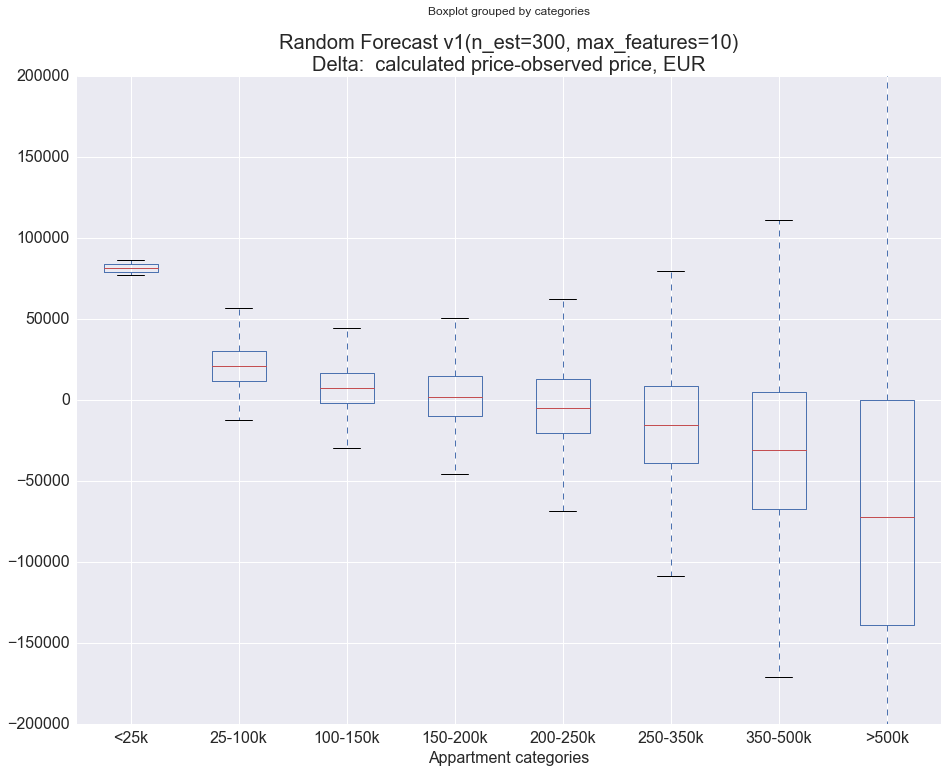

In [470]:
mismatch_boxplot_per_category(predictionQC,"Gradient Boosting v1(n_est=300, max_features=10)")

### Attempt#2 - Gradient boosting (GridSearchCV) with all features

In [472]:
from sklearn.grid_search import GridSearchCV

In [ ]:
parameters = {
              'n_estimators': 300, 
              'max_depth': 10, 
              'min_samples_split': 1,
              'learning_rate': 0.01, 
              'loss': 'ls'
}

In [494]:
n_estimators_list = [50,100,150,300,500]
max_depth_list = [3,5,7,10]
min_samples_split_list=[1,10]
learning_rate_list = [0.01]
param_grid = dict(n_estimators=n_estimators_list,
                  max_depth=max_depth_list,
                  min_samples_split = min_samples_split_list,
                  learning_rate = learning_rate_list)
param_grid

{'learning_rate': [0.01],
 'max_depth': [3, 5, 7, 10],
 'min_samples_split': [1, 10],
 'n_estimators': [50, 100, 150, 300, 500]}

In [497]:
grid = GridSearchCV(ensemble.GradientBoostingRegressor(),param_grid,cv=5,scoring='r2',n_jobs=-1)

In [ ]:
grid.fit(X,Y)

In [ ]:
grid.grid_scores_[1].parameters['n_estimators']
    

In [ ]:
for score_set in grid.grid_scores_:
    print score_set.parameters,score_set.parameters['n_estimators'],score_set.parameters['max_depth']

In [500]:
grid.grid_scores_[0].parameters
grid.grid_scores_[0].cv_validation_scores
grid.grid_scores_[0].mean_validation_score

0.42584763166965323

In [504]:
grid.best_params_

{'learning_rate': 0.01,
 'max_depth': 7,
 'min_samples_split': 1,
 'n_estimators': 500}

In [ ]:
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print grid_mean_scores

In [502]:
predictions = grid.predict(X)

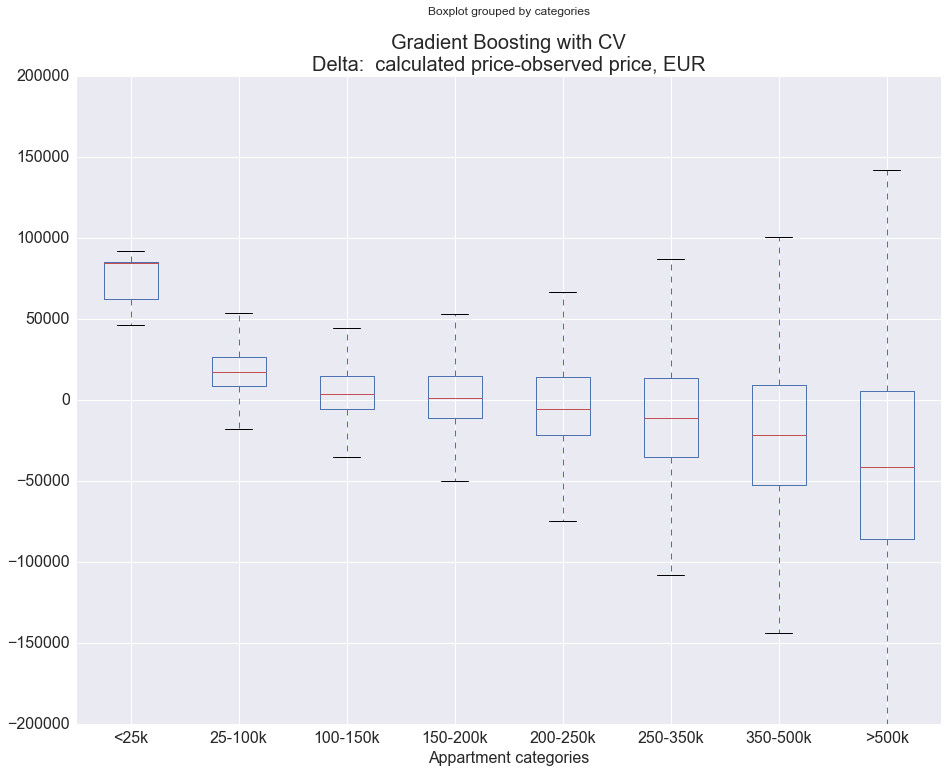

In [503]:
predictionQC = pd.DataFrame({'OBSERVED_PRICE':Y,'PREDICTED_PRICE':predictions}).apply(lambda x: scaler.inverse_transform(x))
predictionQC['delta'] = predictionQC['PREDICTED_PRICE']-predictionQC['OBSERVED_PRICE']
bins = [0,25000,100000,150000,200000,250000,350000,500000,3000000]
group_names = ['<25k', '25-100k', '100-150k', '150-200k','200-250k','250-350k','350-500k','>500k']
predictionQC['categories'] = pd.cut(predictionQC['OBSERVED_PRICE'], bins, labels=group_names)

mismatch_boxplot_per_category(predictionQC,"Gradient Boosting with CV")

The model is overestimated significantly the price for the cheapest appratments (<25 kEUR) and underestimated (in general) the price for expensive apartments (>500kEUR). The prediction for the average price range(100-350 kEUR) is better. The variance of the prediction error is increasing for the appartments with higher price. 

### Attempt#3 - Gradient boosting (GridSearchCV) v2 with all features

In [549]:
n_estimators_list = [750,1000,1250]
max_depth_list = [7]
min_samples_split_list=[1]
learning_rate_list = [0.01]
param_grid = dict(n_estimators=n_estimators_list,
                  max_depth=max_depth_list,
                  min_samples_split = min_samples_split_list,
                  learning_rate = learning_rate_list)
param_grid

{'learning_rate': [0.01],
 'max_depth': [7],
 'min_samples_split': [1],
 'n_estimators': [750, 1000, 1250]}

In [550]:
grid_v2 = GridSearchCV(ensemble.GradientBoostingRegressor(),param_grid,cv=5,scoring='r2',n_jobs=-1)

In [ ]:
grid_v2.fit(X,Y)

In [552]:
grid_v2.best_params_

{'learning_rate': 0.01,
 'max_depth': 7,
 'min_samples_split': 1,
 'n_estimators': 1250}

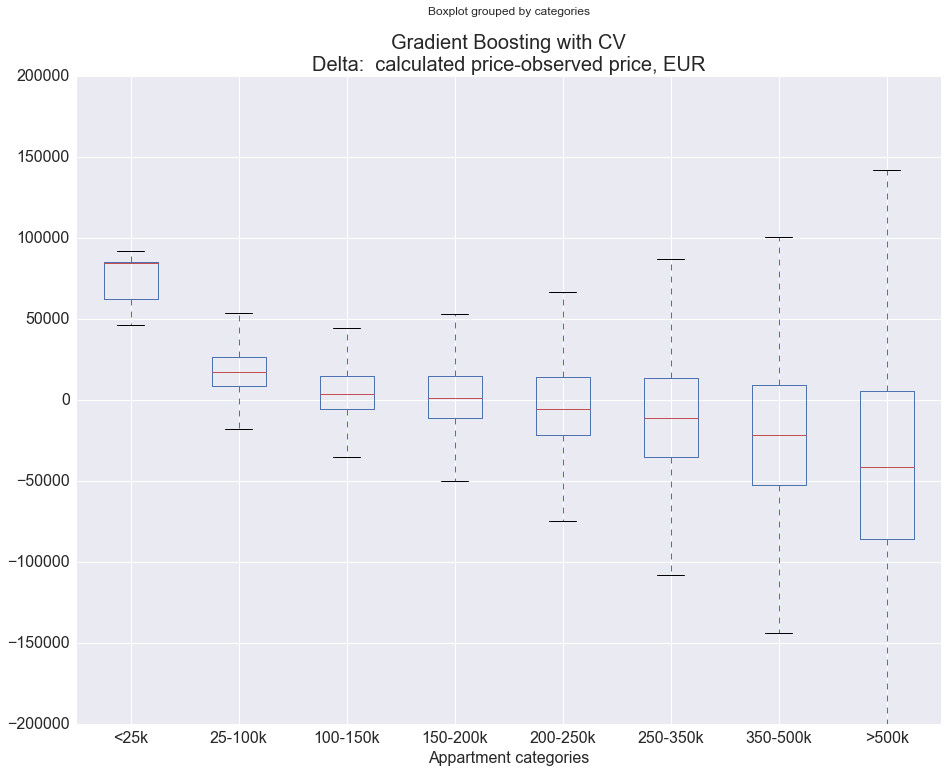

In [553]:
predictions = grid.predict(X)
predictionQC = make_predictionQC_df(Y,predictions)
mismatch_boxplot_per_category(predictionQC,"Gradient Boosting with CV")

In [556]:
grid_v2.grid_scores_[0].parameters
grid_v2.grid_scores_[0].cv_validation_scores
grid_v2.grid_scores_[0].mean_validation_score

0.88774891925830812

### Attempt#4 - Random forest (GridSearchCV) v1 with all features

In [581]:
param_grid = { "n_estimators" : [200],
           "max_features"      : [50],
           "max_depth"         : [7]
           }


In [582]:
grid_v3 = GridSearchCV(ensemble.RandomForestRegressor(),param_grid,cv=5,scoring='r2',n_jobs=-1)

In [ ]:
grid_v3.fit(X,Y)

In [584]:
grid_v3.grid_scores_[0].parameters
grid_v3.grid_scores_[0].cv_validation_scores
grid_v3.grid_scores_[0].mean_validation_score

0.83880030955317575

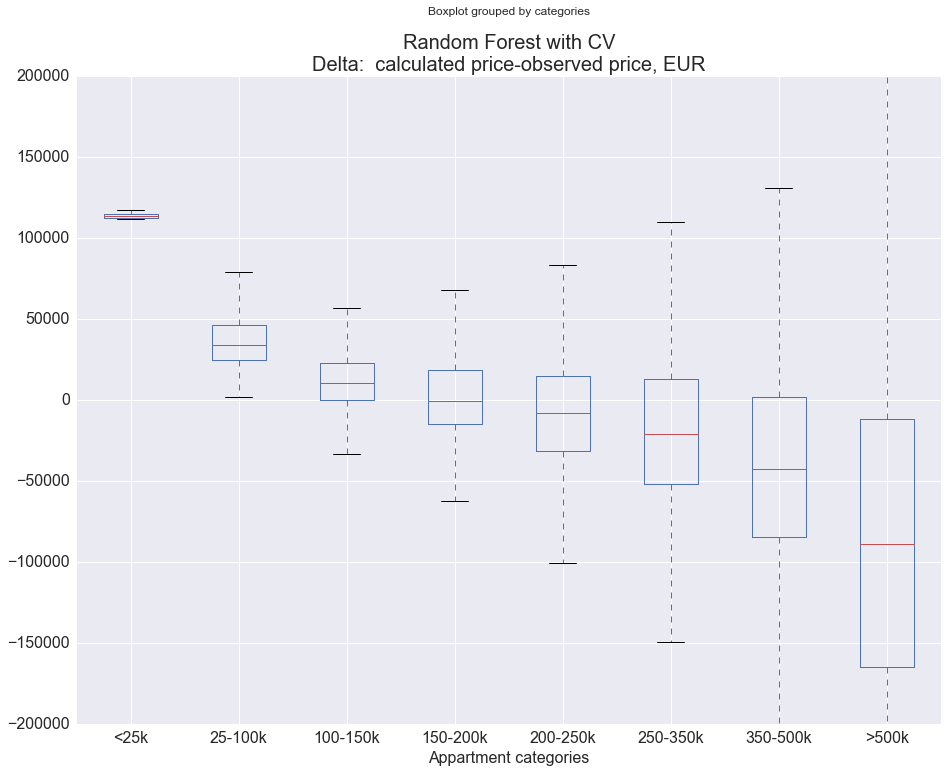

In [585]:
predictions = grid_v3.predict(X)
predictionQC = make_predictionQC_df(Y,predictions)
mismatch_boxplot_per_category(predictionQC,"Random Forest with CV")

### Attempt#5 - Random forest (GridSearchCV) v1 with selected features based on forward stepwise selection

In [ ]:
mean_validation_scores = {}
# Select best 20 features
for idx in range(10,50,1):
    X = df[namesList[:idx]].as_matrix()
    Y = np.ravel(df['SOLD_PRICE'])

    #Standard scaler
    scaler = preprocessing.StandardScaler()

    X = scaler.fit_transform(X)
    Y = scaler.fit_transform(Y)


    param_grid = {"n_estimators":[100,200,300],"max_features":[int(idx/2.0),int(idx/1.5)],"max_depth":[3,5,7]}
    grid_v4 = GridSearchCV(ensemble.RandomForestRegressor(),param_grid,cv=5,scoring='r2',n_jobs=-1)
    grid_v4.fit(X,Y)
    mean_validation_scores[idx] = grid_v4.grid_scores_[0].mean_validation_score
    print grid_v4.grid_scores_[0].mean_validation_score,grid_v4.best_params_